# 1. Entendimiento de los datos

Primero se va a revisar el conjunto de datos para ver si hay suficientes entradas para utilizar los algoritmos de agrupamiento con los cuales se buscará solucionar el problema. Una vez se demuestre que se tienen los datos suficientes se buscará entender los diferentes valores que hay para las distintas columnas

Para la carga y manipulación de datos se utiliza la libreria Pandas (https://pandas.pydata.org/) y para la visualización Matplotlib (https://matplotlib.org/) y Seaborn (https://seaborn.pydata.org/). Primero se realiza la instalación de las librerias necesarias.

In [102]:
%matplotlib inline

In [1]:
pip install ydata-profiling

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Librería para comando de sistema
import os

# Librerías para manejo de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ydata_profiling

# Librerías de aprendizaje automático.
# Para realizar la separación del conjunto de aprendizaje en entrenamiento y test.
from sklearn.model_selection import train_test_split

# Para construir un modelo con el algoritmo de regresión lineal
from sklearn.linear_model import LinearRegression

# Para determinar el rendimiento del modelo con las métricas MSE, MAE y R2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Para sacar un reporte estadístico que podemos usar para determinar las importancia de las variables explicativas.
import statsmodels.api as sm 

#Librerias para la transformación de los datos
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# Librerias para pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, Normalizer
from sklearn.compose import ColumnTransformer

# Librerias para el simple imputer
from sklearn.impute import SimpleImputer

Despues de haber importado las librerias que nos serviran para realizar todo durante el notebook hacemos la carga de los datos de entrenamiento y los de prueba

In [3]:
# Full data son los datos que usaremos para entrenar el modelo
full_data = pd.read_csv('data/data.csv', sep=',', encoding = 'utf-8')

# Test data son los datos usados para probar nuestro modelo
test_data = pd.read_csv('data/data_test.csv', sep=',', encoding = 'utf-8')

In [4]:
# Obtenemos las filas y las columnas de nuestro dataframe
full_data.shape

(7115, 12)

In [5]:
# Almacenamos en una variable para poder realizar todo lo que neceistamos
motoralpes = full_data

In [6]:
# Obtenemos la informacion de los datos
motoralpes.info

<bound method DataFrame.info of       Unnamed: 0    year  km_driven                 owner seller_type  seats  \
0              0     NaN   145500.0                   NaN  Individual    5.0   
1              1  2014.0   120000.0          Second Owner  Individual    5.0   
2              2  2006.0   140000.0           Third Owner  Individual    5.0   
3              3  2010.0   127000.0           First Owner  Individual    5.0   
4              4  2007.0   120000.0           First Owner  Individual    5.0   
...          ...     ...        ...                   ...         ...    ...   
7110        8123  2013.0   110000.0           First Owner  Individual    5.0   
7111        8124  2007.0   119000.0  Fourth & Above Owner  Individual    5.0   
7112        8125  2009.0   120000.0           First Owner  Individual    5.0   
7113        8126  2013.0    25000.0           First Owner  Individual    5.0   
7114        8127  2013.0    25000.0           First Owner  Individual    5.0   

       

In [7]:
# Por ultimo visualizamos los datos usando ydata-profiling
profile = ydata_profiling.ProfileReport(motoralpes)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 2. Identificacion de variables a utilizar

Con la visualizacion anterior sabemos que tenemos 12 variables de las cuales debemos quitar 1 que se llama `Unnamed: 0` porque corresponde a los indices de los datos. De resto usaremos todas las columnas para experimentar e iremos quitando a medida de que lo vayamos considerando

# 3. Preparacion de los datos

Para la preparacion de los datos usaremos pipelines. Esto nos servira para que cuando queramos experimentar con otras columnas podamos realizar esta preparacion rapidamente.

In [8]:
# Veremos los datos que tenemos para realizar las transformaciones necesarias
motoralpes.dtypes

Unnamed: 0         int64
year             float64
km_driven        float64
owner             object
seller_type       object
seats            float64
fuel              object
transmission      object
mileage          float64
engine           float64
max_power        float64
selling_price    float64
dtype: object

Como ahora sabes que tipos de datos tenemos. Vamos a consultar la cantida de nulos para conocer el tipo ed transformaciones que tenemos que hacer. En este punto como vamos a usar todas las columnas lo primero que haremos es convertir las varibales categoricas a numericas. Esto implica usar el OneHotEncoder para crear variables binarias en columnas que representen un dato. Tambien reemplazaremos los datos de Owner por numero secenciales, esto porque tienen una relacion secuencial. Se hacen estas transformaciones primero porque pueden generar nuevos valores nulos. Luego, imputaremos con el metodo de la media en los nulos para las variables numericas que no necesiten un entero. 

In [9]:
# Esto nos permite conocer el tipo de transformaciones que le debemos hacer a los datos numericos
motoralpes.isna().sum()

Unnamed: 0         0
year             239
km_driven        198
owner            239
seller_type        0
seats              0
fuel               0
transmission       0
mileage          198
engine           280
max_power        268
selling_price    401
dtype: int64

In [10]:
#Le aplicaremos una transformacion a las variables categoricas
categoric = ['seller_type','fuel','transmission']

cateNumPipe = Pipeline([
    ("onehot", OneHotEncoder())
])

def replace_owner(x):
    return x.replace(['Test Drive Car', 'First Owner', 'Second Owner', 'Third Owner', 'Fourth & Above Owner'],[0, 1, 2, 3, 4])

# Ahora imputamos con el metodo de la media a los valores que tienen nulos
meanImp = ['km_driven', 'mileage', 'max_power', 'selling_price']
meanImp2 = ['km_driven', 'mileage', 'max_power']
mostFImp = ['year','engine','owner']

numImpPipeMe = Pipeline([
    ("imputerMean", SimpleImputer(strategy="mean"))
])

numImpPipeMe2 = Pipeline([
    ("imputerMean", SimpleImputer(strategy="mean"))
])

numImpPipeMo = Pipeline([
    ("imputerMostF", SimpleImputer(strategy="most_frequent"))
])

In [11]:

pipe = Pipeline([
    ('ownerChange', FunctionTransformer(replace_owner)),
    ('transformer', ColumnTransformer([
        ('impMostF', numImpPipeMo, mostFImp),
        ('impMean', numImpPipeMe, meanImp),
        ('keep', 'passthrough', ['seats']),
        ('Encoder', cateNumPipe,categoric),
    ]))
])

motoralpes_transformed = pipe.fit_transform(motoralpes)
motoralpes_transformed = pd.DataFrame(motoralpes_transformed)
motoralpes_transformed

/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


0        1    2         3      4            5        6    7    8   \
0     2017.0   1248.0  1.0  145500.0  23.40    74.000000  5451.90  5.0  0.0   
1     2014.0   1498.0  2.0  120000.0  21.14   103.520000  4482.68  5.0  0.0   
2     2006.0  13524.0  3.0  140000.0  17.70    78.000000  1914.22  5.0  0.0   
3     2010.0   1248.0  1.0  127000.0  23.00   141.981595  2725.95  5.0  0.0   
4     2007.0   1298.0  1.0  120000.0  16.10    88.200000  1574.99  5.0  0.0   
...      ...      ...  ...       ...    ...          ...      ...  ...  ...   
7110  2013.0   1248.0  1.0  110000.0  18.50  1525.410000  3876.91  5.0  0.0   
7111  2007.0   1493.0  4.0  119000.0  16.80   110.000000  1635.57  5.0  0.0   
7112  2009.0   1248.0  1.0  120000.0  19.30    73.900000  4628.06  5.0  0.0   
7113  2013.0   1396.0  1.0   25000.0  23.57    70.000000  3513.45  5.0  0.0   
7114  2013.0   1396.0  1.0   25000.0  23.57    70.000000  3513.45  5.0  0.0   

       9    10   11   12   13   14   15   16  
0     1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  
1     1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  
2     1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  
3     1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  
4     1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  
...   ...  ...  ...  ...  ...  ...  ...  ...  
7110  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  
7111  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  
7112  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  
7113  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  
7114  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  

[7115 rows x 17 columns]

Una vez tenemos nuestras transformaciones hechas, cambiamos el nombre de las columnas y mostramos el dataframe nuevo

In [12]:
motoralpes_transformed.columns = [
    "year",
    "engine",
    "owner",
    "km_driven",
    "mileage",
    "max_power",
    "selling_price",
    "seats",
    "seller_type_Individual",
    "seller_type_Dealer",
    "seller_type_Trustmark ",
    "fuel_CNG",
    "fuel_Diesel",
    "fuel_LPG",
    "fuel_Petrol",
    "transmission_Automatic",
    "transmission_Manual"
]

motoralpes_transformed

year   engine  owner  km_driven  mileage    max_power  selling_price  \
0     2017.0   1248.0    1.0   145500.0    23.40    74.000000        5451.90   
1     2014.0   1498.0    2.0   120000.0    21.14   103.520000        4482.68   
2     2006.0  13524.0    3.0   140000.0    17.70    78.000000        1914.22   
3     2010.0   1248.0    1.0   127000.0    23.00   141.981595        2725.95   
4     2007.0   1298.0    1.0   120000.0    16.10    88.200000        1574.99   
...      ...      ...    ...        ...      ...          ...            ...   
7110  2013.0   1248.0    1.0   110000.0    18.50  1525.410000        3876.91   
7111  2007.0   1493.0    4.0   119000.0    16.80   110.000000        1635.57   
7112  2009.0   1248.0    1.0   120000.0    19.30    73.900000        4628.06   
7113  2013.0   1396.0    1.0    25000.0    23.57    70.000000        3513.45   
7114  2013.0   1396.0    1.0    25000.0    23.57    70.000000        3513.45   

      seats  seller_type_Individual  seller_type_Dealer  \
0       5.0                     0.0                 1.0   
1       5.0                     0.0                 1.0   
2       5.0                     0.0                 1.0   
3       5.0                     0.0                 1.0   
4       5.0                     0.0                 1.0   
...     ...                     ...                 ...   
7110    5.0                     0.0                 1.0   
7111    5.0                     0.0                 1.0   
7112    5.0                     0.0                 1.0   
7113    5.0                     0.0                 1.0   
7114    5.0                     0.0                 1.0   

      seller_type_Trustmark   fuel_CNG  fuel_Diesel  fuel_LPG  fuel_Petrol  \
0                        0.0       0.0          1.0       0.0          0.0   
1                        0.0       0.0          1.0       0.0          0.0   
2                        0.0       0.0          0.0       0.0          1.0   
3                        0.0       0.0          1.0       0.0          0.0   
4                        0.0       0.0          0.0       0.0          1.0   
...                      ...       ...          ...       ...          ...   
7110                     0.0       0.0          0.0       0.0          1.0   
7111                     0.0       0.0          1.0       0.0          0.0   
7112                     0.0       0.0          1.0       0.0          0.0   
7113                     0.0       0.0          1.0       0.0          0.0   
7114                     0.0       0.0          1.0       0.0          0.0   

      transmission_Automatic  transmission_Manual  
0                        0.0                  1.0  
1                        0.0                  1.0  
2                        0.0                  1.0  
3                        0.0                  1.0  
4                        0.0                  1.0  
...                      ...                  ...  
7110                     0.0                  1.0  
7111                     0.0                  1.0  
7112                     0.0                  1.0  
7113                     0.0                  1.0  
7114                     0.0                  1.0  

[7115 rows x 17 columns]

In [13]:
motoralpes_transformed.isna().sum()

year                      0
engine                    0
owner                     0
km_driven                 0
mileage                   0
max_power                 0
selling_price             0
seats                     0
seller_type_Individual    0
seller_type_Dealer        0
seller_type_Trustmark     0
fuel_CNG                  0
fuel_Diesel               0
fuel_LPG                  0
fuel_Petrol               0
transmission_Automatic    0
transmission_Manual       0
dtype: int64

In [14]:
motoralpes_transformed.duplicated(keep='first').sum()

723

Lo mostrado anteriormente era la comprobacion de las transformaciones hechas. Ahora crearemos el pipeline final que nos ayudara en el proceso de entrenamiento y modelamiento. Las transformaciones hechas no nos arrojan valores nulos pero si repetidos. Pero los repetidos consideramos que son de ayuda para obtener una mayor precision.

# 4. Modelamiento

Primero verificaremos el estado del dataframe de motoralpes. Este para acomodar nuestros datos de entrenamiento y prueba. Aun no se esta usando el archivo para el test, solo estamos partiendo los datos para realizar comprobaciones.

In [15]:
pipeline = Pipeline([
    ('ownerChange', FunctionTransformer(replace_owner)),
    ('transformer', ColumnTransformer([
        ('impMostF', numImpPipeMo, mostFImp),
        ('impMean', numImpPipeMe2, meanImp2),
        ('keep', 'passthrough', ['seats']),
        ('Encoder', cateNumPipe,categoric),
    ])),
    ('normalizer', Normalizer()),
    ('model', LinearRegression())
])

In [16]:
motoralpes.head()

Unnamed: 0    year  km_driven         owner seller_type  seats    fuel  \
0           0     NaN   145500.0           NaN  Individual    5.0  Diesel   
1           1  2014.0   120000.0  Second Owner  Individual    5.0  Diesel   
2           2  2006.0   140000.0   Third Owner  Individual    5.0  Petrol   
3           3  2010.0   127000.0   First Owner  Individual    5.0  Diesel   
4           4  2007.0   120000.0   First Owner  Individual    5.0  Petrol   

  transmission  mileage   engine  max_power  selling_price  
0       Manual    23.40   1248.0      74.00        5451.90  
1       Manual    21.14   1498.0     103.52        4482.68  
2       Manual    17.70  13524.0      78.00        1914.22  
3       Manual    23.00      NaN        NaN        2725.95  
4       Manual    16.10   1298.0      88.20        1574.99

Para las pruebas, nuestro `x` es el dataframe del cual queremos predecir el precio y `y` los precios

In [17]:
motoralpes = motoralpes.dropna()

In [18]:
x_train, x_test, y_train, y_test = train_test_split(motoralpes.drop(['Unnamed: 0','selling_price'],axis=1),motoralpes['selling_price'], test_size=0.3, random_state=1)

In [19]:
x_train.head()

year  km_driven         owner seller_type  seats    fuel transmission  \
3068  2006.0   100000.0  Second Owner  Individual    5.0  Petrol       Manual   
5635  2011.0    87000.0   First Owner  Individual    5.0  Diesel       Manual   
3108  2018.0     9000.0   First Owner  Individual    5.0  Petrol    Automatic   
1087  2009.0   120000.0   First Owner  Individual    5.0  Petrol       Manual   
2635  2009.0   110000.0  Second Owner  Individual    5.0  Petrol       Manual   

      mileage  engine  max_power  
3068     19.7   796.0       46.3  
5635     18.0  1248.0       75.0  
3108     21.4  1197.0       83.1  
1087     19.7   796.0       46.3  
2635     18.2  1061.0       64.0

In [20]:
x_test.head()

year  km_driven         owner       seller_type  seats    fuel  \
1239  2012.0   120000.0   First Owner        Individual    5.0  Diesel   
359   2013.0    58343.0   First Owner  Trustmark Dealer    5.0  Petrol   
6327  2017.0    20000.0   First Owner        Individual    5.0  Petrol   
4113  2004.0   248200.0  Second Owner        Individual    5.0  Diesel   
5237  2018.0    30000.0   First Owner        Individual    5.0  Diesel   

     transmission  mileage  engine  max_power  
1239       Manual    22.32  1582.0     126.32  
359        Manual    21.79   998.0      67.05  
6327    Automatic    20.51   998.0      67.00  
4113       Manual    16.10  1405.0      70.00  
5237       Manual    25.50  1498.0      98.60

In [21]:
y_train.head()

3068    1453.84
5635    2180.76
3108    8965.35
1087    1453.84
2635    1453.84
Name: selling_price, dtype: float64

In [22]:
y_test.head()

1239     4785.56
359      2725.95
6327     5209.60
4113      969.23
5237    10104.19
Name: selling_price, dtype: float64

In [23]:
pipeline.fit(x_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


Pipeline(steps=[('ownerChange',
                 FunctionTransformer(func=<function replace_owner at 0x7fbcd01c5430>)),
                ('transformer',
                 ColumnTransformer(transformers=[('impMostF',
                                                  Pipeline(steps=[('imputerMostF',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['year', 'engine', 'owner']),
                                                 ('impMean',
                                                  Pipeline(steps=[('imputerMean',
                                                                   SimpleImputer())]),
                                                  ['km_driven', 'mileage',
                                                   'max_power']),
                                                 ('keep', 'passthrough',
                                                  ['seats']),
      

In [24]:
pipeline.score(x_test,y_test)

-0.02067631103578993

In [25]:
pipeline.score(x_train,y_train)

0.02658765946065278

In [26]:
np.sqrt(mean_squared_error(y_test, pipeline.predict(x_test)))

41253.66488664096

Como logramos observar, obtuvimos un modelo muy ineficeinte. Por lo que probaremos quitando algunos datos.

Ahora intentaremos evitar quitar los usaremos todos los datos pero con las transformaciones del pipeline y usando la regresion lineal aparte

In [27]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(motoralpes_transformed.drop(['selling_price'],axis=1),motoralpes_transformed['selling_price'], test_size=0.3, random_state=1)

In [28]:
x_train2.head()

year  engine  owner  km_driven  mileage  max_power  seats  \
1839  2007.0  2523.0    3.0   120000.0    13.60       63.0    7.0   
1019  2013.0  1396.0    2.0   175000.0    19.09       69.0    5.0   
6009  2017.0   799.0    1.0     5000.0    25.17       53.3    5.0   
1891  2012.0   998.0    1.0    48000.0    20.92       67.1    5.0   
3477  2012.0  2179.0    3.0   129000.0    15.10      140.0    7.0   

      seller_type_Individual  seller_type_Dealer  seller_type_Trustmark   \
1839                     0.0                 1.0                     0.0   
1019                     0.0                 1.0                     0.0   
6009                     0.0                 1.0                     0.0   
1891                     0.0                 1.0                     0.0   
3477                     0.0                 1.0                     0.0   

      fuel_CNG  fuel_Diesel  fuel_LPG  fuel_Petrol  transmission_Automatic  \
1839       0.0          1.0       0.0          0.0                     0.0   
1019       0.0          1.0       0.0          0.0                     0.0   
6009       0.0          0.0       0.0          1.0                     0.0   
1891       0.0          0.0       0.0          1.0                     0.0   
3477       0.0          1.0       0.0          0.0                     0.0   

      transmission_Manual  
1839                  1.0  
1019                  1.0  
6009                  1.0  
1891                  1.0  
3477                  1.0

In [29]:
x_test2.head()

year  engine  owner  km_driven  mileage  max_power  seats  \
5930  2012.0  1582.0    2.0   146000.0    22.32     126.32    5.0   
2441  2016.0  1197.0    1.0    32000.0    20.40      81.80    5.0   
5028  2014.0  2179.0    1.0    50000.0    15.10     140.00    7.0   
1564  2018.0  1197.0    1.0     5000.0    22.00      81.80    5.0   
5213  2016.0  1248.0    1.0   120000.0    24.52      88.50    7.0   

      seller_type_Individual  seller_type_Dealer  seller_type_Trustmark   \
5930                     0.0                 1.0                     0.0   
2441                     0.0                 1.0                     0.0   
5028                     0.0                 1.0                     0.0   
1564                     0.0                 1.0                     0.0   
5213                     0.0                 1.0                     0.0   

      fuel_CNG  fuel_Diesel  fuel_LPG  fuel_Petrol  transmission_Automatic  \
5930       0.0          1.0       0.0          0.0                     0.0   
2441       0.0          0.0       0.0          1.0                     0.0   
5028       0.0          1.0       0.0          0.0                     0.0   
1564       0.0          0.0       0.0          1.0                     0.0   
5213       0.0          1.0       0.0          0.0                     0.0   

      transmission_Manual  
5930                  1.0  
2441                  1.0  
5028                  1.0  
1564                  1.0  
5213                  1.0

In [30]:
y_train2.head()

1839    11261.208041
1019     2423.070000
6009     3452.870000
1891     3053.070000
3477     7208.630000
Name: selling_price, dtype: float64

In [31]:
y_test2.head()

5930    5633.63
2441    6057.67
5028    9086.50
1564    6663.44
5213    9571.12
Name: selling_price, dtype: float64

In [32]:
regre = LinearRegression()

regre.fit(x_train2,y_train2)

LinearRegression()

In [33]:
regre.score(x_test2,y_test2)

0.037098861788509296

In [34]:
regre.score(x_train2,y_train2)

0.02801346098939672

In [35]:
np.sqrt(mean_squared_error(y_test2, regre.predict(x_test2)))

38249.91186286601

Hemos visto una mejora. Sin embargo siguen siendo resultados poco fiables. Por lo que ahora analizaremos si quitando los duplicados obtenemos un mejor modelo

In [36]:
motoralpes_transformed2 = motoralpes_transformed.drop_duplicates()

In [37]:
x_train3, x_test3, y_train3, y_test3 = train_test_split(motoralpes_transformed2.drop(['selling_price'],axis=1),motoralpes_transformed2['selling_price'], test_size=0.3, random_state=1)

In [38]:
regre2 = LinearRegression()
regre2.fit(x_train3,y_train3)

LinearRegression()

In [39]:
regre2.score(x_test3,y_test3)

8.06034885636464e-06

In [40]:
regre2.score(x_train3,y_train3)

0.029673370050935177

In [41]:
np.sqrt(mean_squared_error(y_test3, regre2.predict(x_test3)))

38873.19191092786

In [42]:
features = [
    "year",
    "engine",
    "owner",
    "km_driven",
    "mileage",
    "max_power",
    "seats",
    "seller_type_Individual",
    "seller_type_Dealer",
    "seller_type_Trustmark ",
    "fuel_CNG",
    "fuel_Diesel",
    "fuel_LPG",
    "fuel_Petrol",
    "transmission_Automatic",
    "transmission_Manual"
]

In [43]:
pd.DataFrame({'columns': features, 'coef': regre2.coef_})

columns          coef
0                     year    421.300054
1                   engine      0.435987
2                    owner  -1086.572804
3                km_driven     -0.007194
4                  mileage   -129.117106
5                max_power     -0.274756
6                    seats    559.950747
7   seller_type_Individual -12410.301186
8       seller_type_Dealer -16957.135390
9   seller_type_Trustmark   29367.436576
10                fuel_CNG  12757.548229
11             fuel_Diesel  -2376.966229
12                fuel_LPG  -6037.979501
13             fuel_Petrol  -4342.602498
14  transmission_Automatic   6010.727749
15     transmission_Manual  -6010.727749

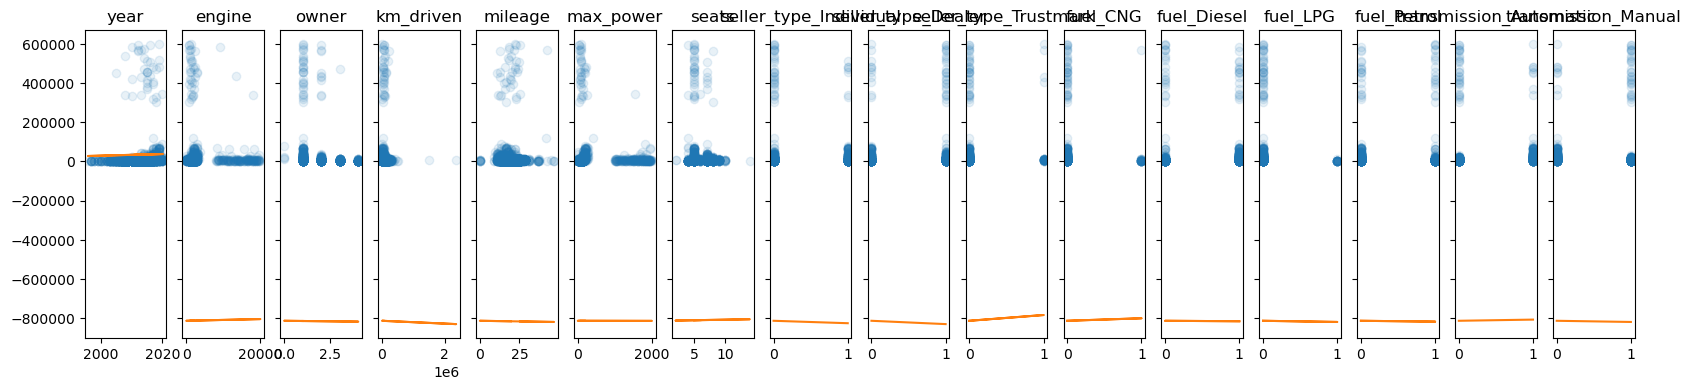

In [55]:
f, axs = plt.subplots(1, len(features), sharey = True, figsize = (20, 4))

for i in range(len(features)):
    col = features[i]
    x = x_train3[col]
    m = regre2.coef_[i]
    b = regre2.intercept_

    axs[i].plot(x, y_train3, 'o', alpha = 0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)

Estamos obteniendo resultados que son ligeramente peores a los que obteniamos por lo que obtaremos por dejarlos. Ahora veremos los outliers y eliminaremos si es necesario

<AxesSubplot:xlabel='year'>

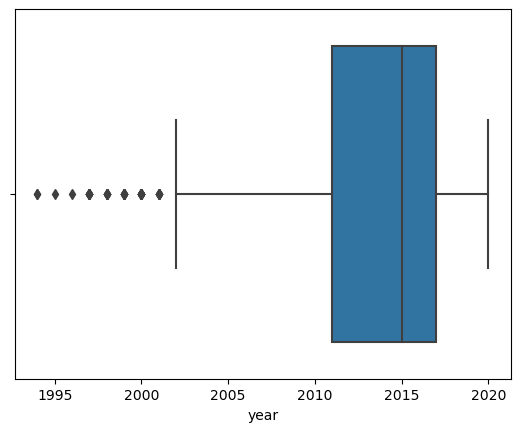

In [103]:
sns.boxplot(x=motoralpes_transformed2['year'], orient="h")

<AxesSubplot:xlabel='engine'>

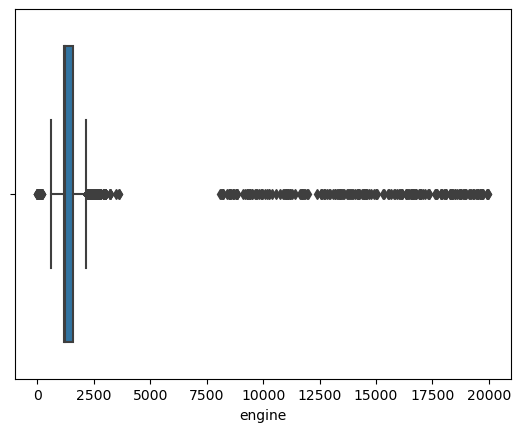

In [104]:
sns.boxplot(x=motoralpes_transformed2['engine'], orient="h")

<AxesSubplot:xlabel='owner'>

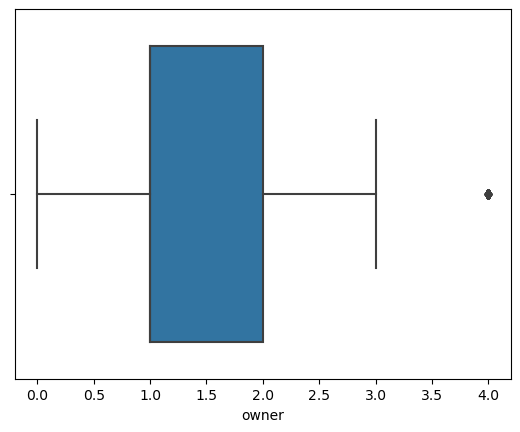

In [105]:
sns.boxplot(x=motoralpes_transformed2['owner'], orient="h")

<AxesSubplot:xlabel='km_driven'>

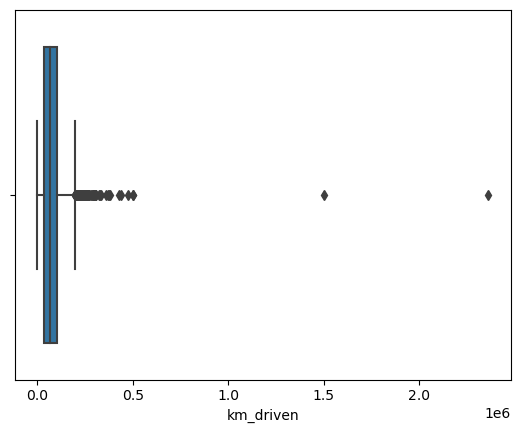

In [106]:
sns.boxplot(x=motoralpes_transformed2['km_driven'], orient="h")

<AxesSubplot:xlabel='mileage'>

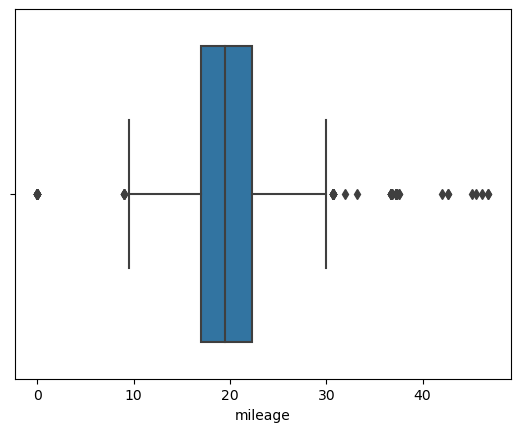

In [107]:
sns.boxplot(x=motoralpes_transformed2['mileage'], orient="h")

<AxesSubplot:xlabel='max_power'>

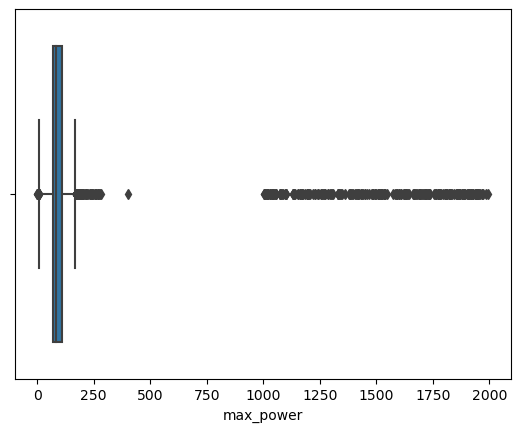

In [108]:
sns.boxplot(x=motoralpes_transformed2['max_power'], orient="h")

<AxesSubplot:xlabel='seats'>

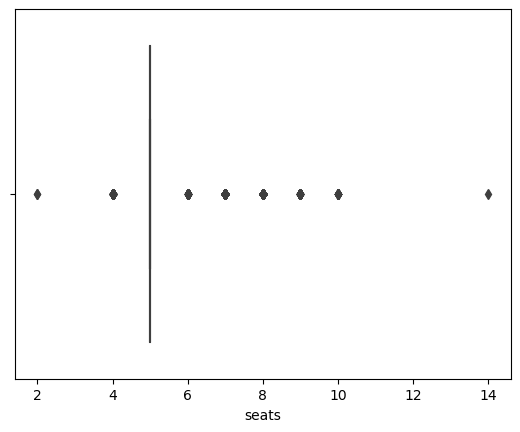

In [109]:
sns.boxplot(x=motoralpes_transformed2['seats'], orient="h")

Como podemos observar en las graficas, tenemos datos muy atipicos que podrian estar afectando el modelo. De esta forma, vamos a eliminarlos utilizando "Interquartile range (IQR)". Esto lo haremos para las columnas `max_power`, `km_driven` y `engine`

In [94]:
# Calcular los quartiles e IQR de la columna Max_power
q1MP = motoralpes_transformed2['max_power'].quantile(0.25)
q3MP = motoralpes_transformed2['max_power'].quantile(0.75)
iqrMP = q3MP - q1MP
# Identificar los limites superiores e inferiores
upperMP = q3MP + 1.5 * iqrMP
lowerMP = q1MP - 1.5 * iqrMP

# Calcular los quartiles e IQR de la columna Km_driven
q1KM = motoralpes_transformed2['km_driven'].quantile(0.25)
q3KM = motoralpes_transformed2['km_driven'].quantile(0.75)
iqrKM = q3KM - q1KM
# Identificar los limites superiores e inferiores
upperKM = q3KM + 1.5 * iqrKM
lowerKM = q1KM - 1.5 * iqrKM

# Calcular los quartiles e IQR de la columna engine
q1EN = motoralpes_transformed2['engine'].quantile(0.25)
q3EN = motoralpes_transformed2['engine'].quantile(0.75)
iqrEN = q3EN - q1EN
# Identificar los limites superiores e inferiores
upperEN = q3EN + 1.5 * iqrEN
lowerEN = q1EN - 1.5 * iqrEN

In [110]:
# Se selccionan las columnas que no son outliers
motoralpes_transformed2 = motoralpes_transformed2[(motoralpes_transformed2['max_power'] >= lowerMP) & (motoralpes_transformed2['max_power'] <= upperMP)]

motoralpes_transformed2 = motoralpes_transformed2[(motoralpes_transformed2['km_driven'] >= lowerKM) & (motoralpes_transformed2['km_driven'] <= upperKM)]

motoralpes_transformed2 = motoralpes_transformed2[(motoralpes_transformed2['engine'] >= lowerEN) & (motoralpes_transformed2['engine'] <= upperEN)]

<AxesSubplot:xlabel='max_power'>

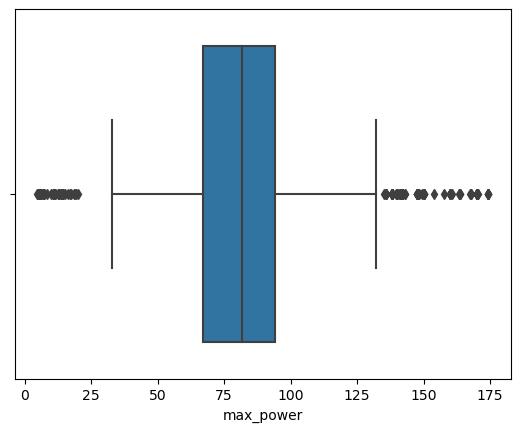

In [111]:
sns.boxplot(x=motoralpes_transformed2['max_power'], orient="h")

<AxesSubplot:xlabel='km_driven'>

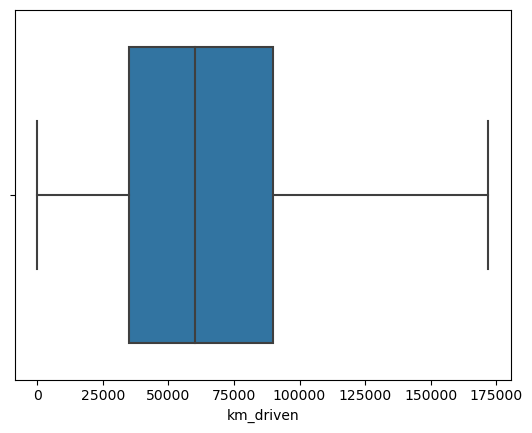

In [112]:
sns.boxplot(x=motoralpes_transformed2['km_driven'], orient="h")

<AxesSubplot:xlabel='engine'>

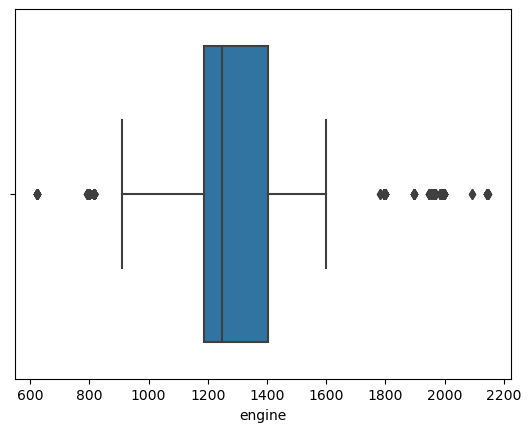

In [113]:
sns.boxplot(x=motoralpes_transformed2['engine'], orient="h")

Una evz eliminados los outliers podemos volver a probar el modelo.

In [114]:
x_train4, x_test4, y_train4, y_test4 = train_test_split(motoralpes_transformed2.drop(['selling_price'],axis=1),motoralpes_transformed2['selling_price'], test_size=0.3, random_state=1)

In [115]:
regre3 = LinearRegression()
regre3.fit(x_train4,y_train4)

LinearRegression()

In [117]:
regre3.score(x_test4,y_test4)

0.007102310631511899

In [118]:
regre3.score(x_train4,y_train4)

0.012149971167557894

In [119]:
np.sqrt(mean_squared_error(y_test4, regre3.predict(x_test4)))

41123.512618605666

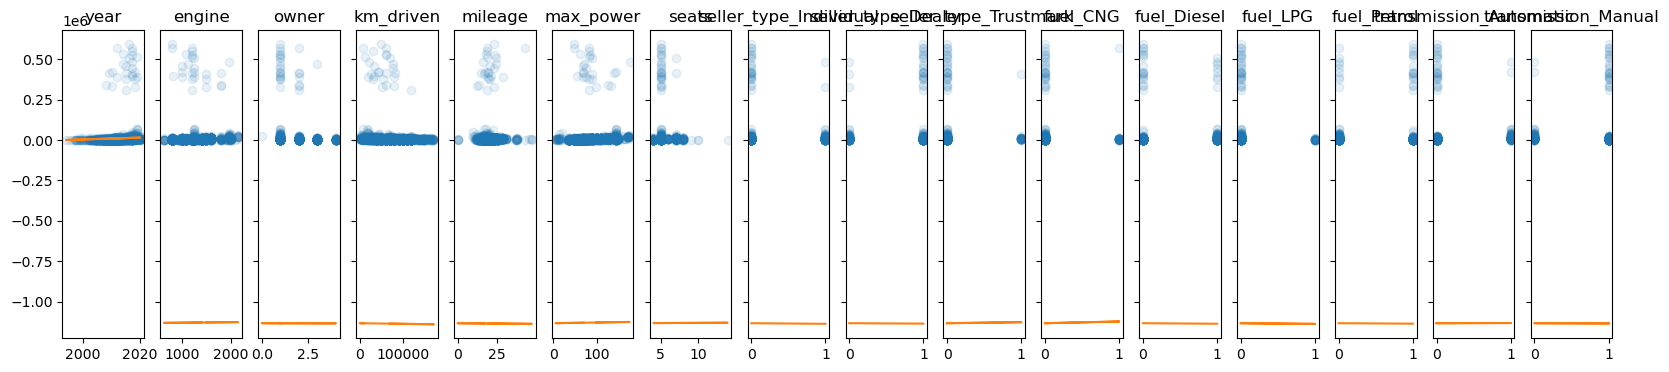

In [121]:
f2, axs2 = plt.subplots(1, len(features), sharey = True, figsize = (20, 4))

for i in range(len(features)):
    col = features[i]
    x = x_train4[col]
    m = regre3.coef_[i]
    b = regre3.intercept_

    axs2[i].plot(x, y_train4, 'o', alpha = 0.1)
    axs2[i].plot(x, x * m + b)
    axs2[i].set_title(col)

Como podemos ver el modelo sigue siendo poco preciso.

In [122]:
pd.DataFrame({'columns': features, 'coef': regre3.coef_})

columns          coef
0                     year    568.334722
1                   engine      3.218654
2                    owner   -199.635648
3                km_driven     -0.038481
4                  mileage    -81.354290
5                max_power     45.030175
6                    seats    207.413348
7   seller_type_Individual  -3717.996197
8       seller_type_Dealer  -2630.218449
9   seller_type_Trustmark    6348.214645
10                fuel_CNG  10601.103754
11             fuel_Diesel  -3334.962564
12                fuel_LPG  -4326.829352
13             fuel_Petrol  -2939.311838
14  transmission_Automatic   1132.962834
15     transmission_Manual  -1132.962834

Lo que podemos observar es que para tener un modelo mas preciso debemos dejar de tener en cuenta columnas como `seller_type_...`, `fuel_...` y `transmission_...`

In [128]:
motoralpes_drop = motoralpes_transformed2.drop(['seller_type_Individual','seller_type_Dealer','fuel_CNG','fuel_Diesel','fuel_LPG','fuel_Petrol','transmission_Automatic','transmission_Manual'], axis=1)

Se debe escoger el nuevo dataframe de forma manual porque por alguna razon no funciona la funcion drop para `seller_type_Trustmark`

In [133]:
motoralpes_drop = motoralpes_drop[['year','engine','owner','km_driven','mileage','max_power','selling_price','seats']]

In [134]:
motoralpes_drop

year  engine  owner  km_driven  mileage   max_power  selling_price  \
0     2017.0  1248.0    1.0   145500.0    23.40   74.000000    5451.900000   
1     2014.0  1498.0    2.0   120000.0    21.14  103.520000    4482.680000   
3     2010.0  1248.0    1.0   127000.0    23.00  141.981595    2725.950000   
4     2007.0  1298.0    1.0   120000.0    16.10   88.200000    1574.990000   
7     2001.0   796.0    2.0     5000.0    16.10   37.000000     545.190000   
...      ...     ...    ...        ...      ...         ...            ...   
7108  2013.0   998.0    2.0    50000.0    18.90   67.100000    3149.990000   
7109  2014.0  1396.0    2.0    80000.0    22.54   88.730000   11261.208041   
7111  2007.0  1493.0    4.0   119000.0    16.80  110.000000    1635.570000   
7112  2009.0  1248.0    1.0   120000.0    19.30   73.900000    4628.060000   
7113  2013.0  1396.0    1.0    25000.0    23.57   70.000000    3513.450000   

      seats  
0       5.0  
1       5.0  
3       5.0  
4       5.0  
7       4.0  
...     ...  
7108    5.0  
7109    5.0  
7111    5.0  
7112    5.0  
7113    5.0  

[4850 rows x 8 columns]

Volvemos a hacer la evaluacion

In [135]:
x_train5, x_test5, y_train5, y_test5 = train_test_split(motoralpes_drop.drop(['selling_price'],axis=1),motoralpes_drop['selling_price'], test_size=0.3, random_state=1)

In [136]:
regre4 = LinearRegression()
regre4.fit(x_train5,y_train5)

LinearRegression()

In [137]:
regre4.score(x_test5,y_test5)

0.00028021090031671303

In [138]:
regre4.score(x_train5,y_train5)

0.01017940891789848

In [139]:
np.sqrt(mean_squared_error(y_test5, regre4.predict(x_test5)))

41264.54852311727

# 5. Evaluacion cuantitativa

### 5.1 Recomendamos instalar el modelo de estimacion?

### 5.2 Que posibilidades tiene la empresa?

# 6. Evaluacion Cualitativa

### 6.1 Validacion de supuestos

### 6.2 Interpretacion de coeficientes

# 7. Visualizar el resultado del modelo

# 8. Exportar el modelo